# Tutorial (Structured Data Processing)

:::{warning}
This page is under construction and not finished yet. Do not use it.
:::

(Last updated: Feb 13, 2023)

This tutorial will familiarize you with the data science pipeline of processing structured data, using a real-world example of building models to predict and explain the presence of bad smell events in Pittsburgh using air quality and weather data. The models are used to send push notifications about bad smell events to inform citizens, as well as to explain local pollution patterns to inform stakeholders.


The scenario is in the next section of this tutorial, and more details are in the introduction section of the [Smell Pittsburgh paper](https://doi.org/10.1145/3369397). We will use the [same dataset as used in the Smell Pittsburgh paper](https://github.com/CMU-CREATE-Lab/smell-pittsburgh-prediction/tree/master/dataset/v1) as an example of structured data. During this tutorial, we will explain what the variables in the dataset mean and also guide you through model building.

You can use the following link to jump to the tasks and assignments:
- [Task 4: Preprocess Sensor Data](#t4)
  - [Assignment for Task 4](#a4)
- [Task 5: Preprocess Smell Data](#t5)
  - [Assignment for Task 5](#a5)
- [Task 6: Prepare Features and Labels](#t6)
  - [Assignment for Task 6](#a6)
- [Task 7: Train and Evaluate Models](#t7)
  - [Use the Dummy Classifier](#dummy-classifier)
  - [Use the Decision Tree Model](#decision-tree)
  - [Use the Random Forest Model](#random-forest)
  - [Compute Feature Importance](#feature-importance)
  - [Assignment for Task 7](#a7)
- [Optional Assignment](#opa)

## Scenario

Local citizens in Pittsburgh are organizing communities to advocate for changes in air pollution regulations. Their goal is to investigate the air pollution patterns in the city to understand the potential sources related to the bad odor. The communities rely on the Smell Pittsburgh application (as indicated in the figure below) to collect smell reports from citizens that live in the Pittsburgh region. Also, there are air quality and weather monitoring stations in the Pittsburgh city region that provide sensor measurements, including common air pollutants and wind information.

\
<img src="../../../assets/images/smellpgh-ui.png" style="max-width: 700px;">

\
You work in a data science team to develop models to map the sensor data to bad smell events. Your team has been working with the Pittsburgh local citizens closely for a long time, and therefore you know the meaning of each variable in the feature set that is used to train the machine learning model. The Pittsburgh community needs your help timely to analyze the data that can help them present evidence of air pollution to the municipality and explain the patterns to the general public.

## Import Packages

We put all the packages that are needed for this tutorial below:

In [1]:
import pandas as pd
import numpy as np
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import isfile, join
from os import listdir
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from pandas.api.indexers import FixedForwardWindowIndexer

## Task Answers

The code block below contains answers for the assignments in this tutorial. **Do not check the answers in the next cell before practicing the tasks.**

In [2]:
def check_answer_df(df_result, df_answer, n=1):
    """
    This function checks if two output dataframes are the same.
    
    Parameters
    ----------
    df_result : pandas.DataFrame
        The result from the output of a function.
    df_answer: pandas.DataFrame
        The expected output of the function.
    n : int
        The numbering of the test case.
    """
    try:
        assert df_answer.equals(df_result)
        print("Test case %d passed." % n)
    except:
        print("Test case %d failed." % n)
        print("")
        print("Your output is:")
        print(df_result)
        print("")
        print("Expected output is:")
        print(df_answer)

        
def answer_preprocess_sensor(df_list):
    """
    This function is the answer of task 5.
    Preprocess sensor data.
    
    Parameters
    ----------
    df_list : list of pandas.DataFrame
        A list of data frames that contain sensor data from multiple stations.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed sensor data.
    """
    # Resample all the data frames.
    df_resample_list = []
    for df in df_list:
        # Convert the timestamp to datetime.
        df.index = pd.to_datetime(df.index, unit="s", utc=True)
        # Resample the timestamps by hour and average all the previous values.
        # Because we want data from the past, so label need to be "right".
        df_resample_list.append(df.resample("60Min", label="right").mean())
    
    # Merge all data frames.
    df = df_resample_list.pop(0)
    index_name = df.index.name
    while len(df_resample_list) != 0:
        # We need to use outer merging since we want to preserve data from both data frames.
        df = pd.merge_ordered(df, df_resample_list.pop(0), on=df.index.name, how="outer", fill_method=None)
        # Move the datetime column to index
        df = df.set_index(index_name)

    # Fill in the missing data with value -1.
    df = df.fillna(-1)
    return df


def answer_preprocess_smell(df):
    """
    This function is the answer of task 4.
    Preprocess smell data.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The raw smell reports data.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed smell data.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)
    
    # Drop the columns that we do not need.
    df = df.drop(columns=["feelings_symptoms", "smell_description", "zipcode"])
    
    # Select only the reports within the range of 3 and 5.
    df = df[(df["smell_value"]>=3)&(df["smell_value"]<=5)]
    
    # Convert the timestamp to datetime.
    df.index = pd.to_datetime(df.index, unit="s", utc=True)

    # Resample the timestamps by hour and sum up all the future values.
    # Because we want data from the future, so label need to be "left".
    df = df.resample("60Min", label="left").sum()
    
    # Fill in the missing data with value 0.
    df = df.fillna(0)
    return df


def answer_sum_current_and_future_data(df, n_hr=0):
    """
    This function is the answer of task 6.
    Sum up data in the current and future hours.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    n_hr : int
         Number of hours that we want to sum up the future smell data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed smell data.
    """
    # Copy data frame to prevent editing the original one.
    df = df.copy(deep=True)
    
    # Fast return if n_hr is 0
    if n_hr == 0: return df
    
    # Sum up all smell_values in future hours.
    # The rolling function only works for summing up previous values.
    # So we need to shift back to get the value in the future.
    # Be careful that we need to add 1 to the rolling window size.
    # Becasue window size 1 means only using the current data.
    # Parameter "closed" need to be "right" because we want the current data.
    df = df.rolling(n_hr+1, min_periods=1, closed="right").sum().shift(-1*n_hr)
    
    # Below is an alternative implementation of rolling.
    #indexer = FixedForwardWindowIndexer(window_size=n_hr+1)
    #df = df.rolling(indexer, min_periods=1).sum()
    
    # Delete the last n_hr rows.
    # These n_hr rows have wrong data due to data shifting.
    df = df.iloc[:-1*n_hr]
    return df


def answer_experiment(df_x, df_y):
    """
    This function is the answer of task 7.
    Perform experiments and print the results.
    
    Parameters
    ----------
    df_x : pandas.DataFrame
        The data frame that contains all features.
    df_y : pandas.DataFrame
         The data frame that contains labels.
    """
    fs1 = ["3.feed_28.H2S_PPM_pre_1h", "day_of_week", "hour_of_day"]
    fs1w = fs1 + ["3.feed_28.SONICWD_DEG_sine_pre_1h", "3.feed_28.SONICWD_DEG_cosine_pre_1h"]
    fs2 = fs1 + ["3.feed_28.H2S_PPM_pre_2h"]
    fs2w = fs2 + ["3.feed_28.SONICWD_DEG_sine_pre_2h", "3.feed_28.SONICWD_DEG_cosine_pre_2h"]
    feature_sets = [fs1, fs1w, fs2, fs2w]
    models = [DecisionTreeClassifier(), RandomForestClassifier()]
    for m in models:
        for fs in feature_sets:
            print("Use feature set %s" % (str(fs)))
            df_x_fs = df_x[fs]
            train_and_evaluate(m, df_x_fs, df_y, train_size=336, test_size=168)
            compute_feature_importance(m, df_x_fs, df_y, scoring="f1")
            print("")

<a name="t4"></a>

## Task 4: Preprocess Sensor Data

In this task, we will process the sensor data from various air quality monitoring stations in Pittsburgh. First, we need to load all the sensor data.

In [3]:
path = "../../../assets/datasets/smellpgh-v1/esdr_raw"
list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
sensor_raw_list = []
for f in list_of_files:
    sensor_raw_list.append(pd.read_csv(join(path, f)).set_index("EpochTime"))

Now, the `sensor_raw_list` variable contains all the data frames with sensor values from different air quality monitoring stations. Noted that `sensor_raw_list` is an array of data frames. We can print one of them to take a look, as shown below. 

In [4]:
sensor_raw_list[0]

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH
EpochTime,,,,,
1477891800,0.0,0.0,51.7,343.0,3.6
1477895400,0.0,0.0,52.7,351.0,3.5
1477899000,0.0,0.0,52.6,359.0,3.4
1477902600,0.0,0.0,48.3,5.0,2.1
1477906200,0.0,0.0,31.1,41.0,2.2
...,...,...,...,...,...
1538267400,0.0,0.0,35.2,39.0,1.7
1538271000,0.0,0.0,48.2,53.0,1.3
1538274600,0.0,0.0,30.9,62.0,1.5


The `EpochTime` index is the timestamp in epoch time, which means the number of seconds that have elapsed since January 1st, 1970 (midnight UTC/GMT). Other columns mean the sensor data from an air quality monitoring station.

Next, we need to resample and merge all the sensor data frames so that they can be used for modeling. Our goal is to have a dataframe that looks like the following:

In [5]:
df_sensor = answer_preprocess_sensor(sensor_raw_list)
df_sensor

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH,3.feed_23.CO_PPM,3.feed_23.PM10_UG_M3,3.feed_29.PM10_UG_M3,3.feed_29.PM25_UG_M3,3.feed_11067.CO_PPB..3.feed_43.CO_PPB,...,3.feed_3.SO2_PPM,3.feed_3.SONICWD_DEG,3.feed_3.SONICWS_MPH,3.feed_3.SIGTHETA_DEG,3.feed_3.PM10B_UG_M3,3.feed_5975.PM2_5,3.feed_27.NO_PPB,3.feed_27.NOY_PPB,3.feed_27.CO_PPB,3.feed_27.SO2_PPB
EpochTime,,,,,,,,,,,,,,,,,,,,,
2016-10-31 06:00:00+00:00,0.0,0.0,51.7,343.0,3.6,0.2,7.0,8.0,8.0,159.5,...,0.0,344.0,2.9,43.0,9.0,0.0,0.1,2.6,-1.0,0.2
2016-10-31 07:00:00+00:00,0.0,0.0,52.7,351.0,3.5,0.2,8.0,8.0,8.0,-1.0,...,0.0,330.0,2.5,43.6,13.0,5.0,-1.0,-1.0,106.1,0.0
2016-10-31 08:00:00+00:00,0.0,0.0,52.6,359.0,3.4,0.2,5.0,7.0,7.0,133.0,...,0.0,0.0,3.1,40.9,7.0,9.0,0.2,2.1,105.8,-1.0
2016-10-31 09:00:00+00:00,0.0,0.0,48.3,5.0,2.1,0.2,3.0,4.0,4.0,236.6,...,0.0,325.0,1.9,40.0,11.0,3.0,0.1,3.1,111.7,0.0
2016-10-31 10:00:00+00:00,0.0,0.0,31.1,41.0,2.2,0.2,5.0,5.0,4.0,269.3,...,0.0,347.0,1.4,45.1,10.0,9.0,0.1,2.5,127.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 01:00:00+00:00,0.0,0.0,35.2,39.0,1.7,0.3,20.0,15.0,10.0,455.1,...,0.0,39.0,1.3,57.3,11.0,5.0,0.1,12.1,301.0,0.0
2018-09-30 02:00:00+00:00,0.0,0.0,48.2,53.0,1.3,0.3,25.0,19.0,12.0,761.2,...,0.0,70.0,1.0,54.4,21.0,7.0,0.2,13.5,357.7,0.0
2018-09-30 03:00:00+00:00,0.0,0.0,30.9,62.0,1.5,0.4,23.0,55.0,33.0,1125.4,...,0.0,75.0,0.7,59.5,33.0,8.0,0.6,13.8,373.6,0.0


In the expected output above, the `EpochTime` index is converted from timestamps into [pandas datetime](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html#pandas.DatetimeIndex) objects, which has the format `year-month-day hour:minute:second+timezone`. The `+00:00` string means the GMT/UTC timezone. Other columns mean the average value of the sensor data in the previous hour. For example, `2016-10-31 06:00:00+00:00` means October 31 in 2016 at 6AM UTC time, and the cell with column `3.feed_1.SO2_PPM` means the averaged SO2 (sulfur dioxide) values from 5:00 to 6:00.

The column name suffix `SO2_PPM` means sulfur dioxide in unit PPM (parts per million). The prefix `3.feed_1.` in the column name means a specific sensor (feed ID 1). You can ignore the `3.` at the begining of the column name. You can find the list of sensors, their names with feed ID (which will be in the data frame columns), and also the meaning of all the suffixes from [this link](https://github.com/CMU-CREATE-Lab/smell-pittsburgh-prediction/tree/master/dataset/v2.1#description-of-the-air-quality-sensor-data).

Some column names look like `3.feed_11067.SIGTHETA_DEG..3.feed_43.SIGTHETA_DEG`. This means that the column has data from two sensor stations (feed ID 11067 and 43). The reason is that some sensor stations are replaced by the new ones over time. So in this case, we merge sensor readings from both feed ID 11067 and 43. 

<a name="a4"></a>

### Assignment for Task 4

**Your task (which is your assignment) is to write a function to do the following:**
- Sensors can report in various frequencies. So, for each data frame, we need to resample the data by computing the hourly average of sensor measurements from the "previous" hour. For example, at time 8:00, we want to know the average of sensor values between 7:00 and 8:00.
  - Hint: Use the `pandas.to_datetime` function when converting timestamps to datetime objects. Type `?pd.to_datetime` in a code cell for more information.
  - Hint: Use the `pandas.DataFrame.resample` function to resample data. Type `?pd.DataFrame.resample` in a code cell for more information.
  - Hint: Use the `pandas.merge_ordered` function when merging data frames. Type `?pd.merge_ordered` in a code cell for more information.
- Then, merge all the data frames based on their time stamp, which is the `EpochTime` column.
- Finally, fill in the missing data with the value -1. The reason for not using 0 is that we want the model to know if sensors give values (including zero) or no data.
  - Hint: Use the `pandas.DataFrame.fillna` function when treating missing values. Type `?pd.DataFrame.fillna` in a code cell for more information.

In [6]:
def preprocess_sensor(df_list):
    """
    Preprocess sensor data.
    
    Parameters
    ----------
    df_list : list of pandas.DataFrame
        A list of data frames that contain sensor data from multiple stations.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed sensor data.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

The code below tests if the output of your function matches the expected output.

In [7]:
check_answer_df(preprocess_sensor(sensor_raw_list), df_sensor, n=1)

Test case 1 failed.

Your output is:
None

Expected output is:
                           3.feed_1.SO2_PPM  3.feed_1.H2S_PPM  \
EpochTime                                                       
2016-10-31 06:00:00+00:00               0.0               0.0   
2016-10-31 07:00:00+00:00               0.0               0.0   
2016-10-31 08:00:00+00:00               0.0               0.0   
2016-10-31 09:00:00+00:00               0.0               0.0   
2016-10-31 10:00:00+00:00               0.0               0.0   
...                                     ...               ...   
2018-09-30 01:00:00+00:00               0.0               0.0   
2018-09-30 02:00:00+00:00               0.0               0.0   
2018-09-30 03:00:00+00:00               0.0               0.0   
2018-09-30 04:00:00+00:00               0.0               0.0   
2018-09-30 05:00:00+00:00               0.0               0.0   

                           3.feed_1.SIGTHETA_DEG  3.feed_1.SONICWD_DEG  \
EpochTime        

<a name="t5"></a>

## Task 5: Preprocess Smell Data

In this task, we will preprocess the smell data. First, we need to load the raw smell data.

In [8]:
smell_raw = pd.read_csv("../../../assets/datasets/smellpgh-v1/smell_raw.csv").set_index("EpochTime")
smell_raw

,feelings_symptoms,smell_description,smell_value,zipcode
EpochTime,,,,
1477935134,NaN,NaN,1,15221
1477956180,NaN,Woodsmoke,2,15218
1477956293,NaN,Wood smoke,3,15218
1477973293,"Eye irritation, nose burns, headache, woke me up",Industrial,5,15207
1478001989,NaN,Industrial smoke,2,15213
...,...,...,...,...
1538248172,NaN,Sour sewage,3,15213
1538255258,Coughing,Smoke,2,15104
1538268796,NaN,Like a burning candle,3,15232


The meaning of `EpochTime` is explained in the previous task. Other columns mean the self-reported symptoms, descriptions of smell, severity ratings (the `smell_value` column), and the zipcode where the report is submitted in Pittsburgh, Pennsylvania. For example, the second row means that the smell report was submitted from the 15218 zipcode with wood smoke description and severity rating 2. For more description about the smell, please check the [Smell Pittsburgh website](https://smellpgh.org/how_it_works).

Next, we need to resample the smell data so that they can be used for modeling. Our goal is to have a dataframe that looks like the following:

In [9]:
df_smell = answer_preprocess_smell(smell_raw)
df_smell

,smell_value
EpochTime,
2016-10-31 23:00:00+00:00,3
2016-11-01 00:00:00+00:00,0
2016-11-01 01:00:00+00:00,0
2016-11-01 02:00:00+00:00,0
2016-11-01 03:00:00+00:00,0
...,...
2018-09-30 00:00:00+00:00,3
2018-09-30 01:00:00+00:00,0
2018-09-30 02:00:00+00:00,0


In the latest row, the timestamp is `2018-09-30 04:00:00+00:00`, which means this row contains the data from 3:00 to 4:00 on September 30 in 2018. This row has `smell_value` 8, which means the sum of smell report ratings in the above mentioned time range. Notice that the expected output ignores all smell ratings from 1 to 2. This is becasue we only want the ratings that indicate bad smell, which will be further explained below.

<a name="a5"></a>

### Assignment for Task 5

**Your task (which is your assignment) is to write a function to do the following:**
- First, remove the `feelings_symptoms`, `smell_description`, and `zipcode` columns since we do not need them.
  - Hint: Use the `pandas.DataFrame.drop` function. Type `?pd.DataFrame.drop` in a code cell for more information.
- We only want the reports that indicate bad smell. You need to select only the reports with rating 3, 4, or 5 in the `smell_value` column.
- Then, we want to know the severity of bad smell within an hour in the future. For example, at time 8:00, we want to know the sum of smell values between 8:00 and 9:00. So you need to resample the data by computing the hourly sum of smell values from the "future" hour.
  - Hint: Use the `pandas.to_datetime` function when converting timestamps to datetime objects. Type `?pd.to_datetime` in a code cell for more information.
  - Hint: Use the `pandas.DataFrame.resample` function to resample data. Type `?pd.DataFrame.resample` in a code cell for more information.
- Finally, fill in the missing data with the value 0. The reason is that missing data means there are no smell reports (provided by citizens) within an hour, so we assume that there is no bad smell within this period of time. Notice that this is an assumption and also a limitation since citizens rarely report good smell.
  - Hint: Use the `pandas.DataFrame.fillna` function when treating missing values. Type `?pd.DataFrame.fillna` in a code cell for more information.

In [10]:
def preprocess_smell(df):
    """
    Preprocess smell data.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The raw smell reports data.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed smell data.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

The code below tests if the output of your function matches the expected output.

In [11]:
check_answer_df(preprocess_smell(smell_raw), df_smell, n=1)

Test case 1 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-10-31 23:00:00+00:00            3
2016-11-01 00:00:00+00:00            0
2016-11-01 01:00:00+00:00            0
2016-11-01 02:00:00+00:00            0
2016-11-01 03:00:00+00:00            0
...                                ...
2018-09-30 00:00:00+00:00            3
2018-09-30 01:00:00+00:00            0
2018-09-30 02:00:00+00:00            0
2018-09-30 03:00:00+00:00            0
2018-09-30 04:00:00+00:00            8

[16758 rows x 1 columns]


Now, we can plot the distribution of smell values by using the `pandas.DataFrame.plot` function.

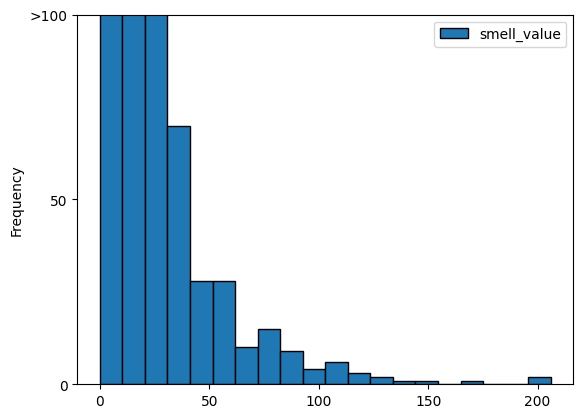

In [12]:
fig = df_smell.plot(kind="hist", bins=20, ylim=(0,100), edgecolor="black").set_yticks([0,50,100], labels=["0","50",">100"])

From the plot above, we can observe that a lot of the time, the smell values are fairly low. This means that smell events only happen occasionally, and thus our dataset is highly imbalanced.

We can also plot the average number of smell reports distributed by the day of week (Sunday to Saturday) and the hour of day (0 to 23), using the code below.

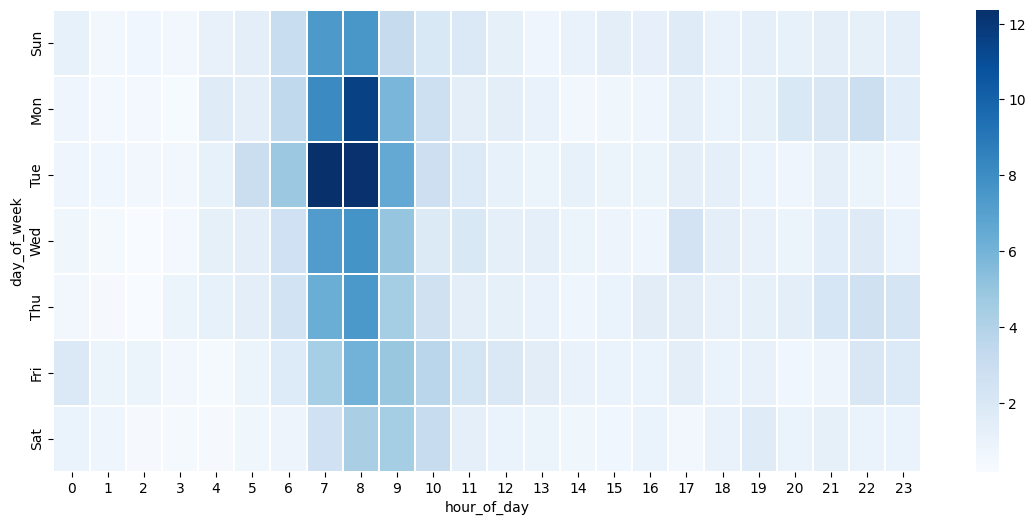

In [13]:
def is_datetime_obj_tz_aware(dt):
    """
    Find if the datetime object is timezone aware.
    
    Parameters
    ----------
    dt : pandas.DatetimeIndex
        A datatime index object.
    """
    return dt.tzinfo is not None and dt.tzinfo.utcoffset(dt) is not None


def plot_smell_by_day_and_hour(df):
    """
    Plot the average number of smell reports by the day of week and the hour of day.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    """
    # Copy the data frame to prevent editing the original one.
    df = df.copy(deep=True)
    
    # Convert timestamps to the local time in Pittsburgh.
    if is_datetime_obj_tz_aware(df.index):
        df.index = df.index.tz_convert(pytz.timezone("US/Eastern"))
    else:
        df.index = df.index.tz_localize(pytz.utc, ambiguous="infer").tz_convert(pytz.timezone("US/Eastern"))
    
    # Compute the day of week and the hour of day.
    df["day_of_week"] = df.index.dayofweek
    df["hour_of_day"] = df.index.hour
    
    # Plot the graph.
    y_l = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    df_pivot = pd.pivot_table(df, values="smell_value", index=["day_of_week"], columns=["hour_of_day"], aggfunc=np.mean)
    f, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(df_pivot, annot=False, cmap="Blues", fmt="g", linewidths=0.1, yticklabels=y_l, ax=ax)
    
    
plot_smell_by_day_and_hour(df_smell)

From the plot above, we can observe that citizens tend to report smell in the morning.

<a name="t6"></a>

## Task 6: Prepare Features and Labels

Now we have the preprocessed data in the `df_sensor` and `df_smell` variables. Our next task is to prepare features and labels for modeling, as shown in the figure below.

\
<img src="../../../assets/images/smellpgh-predict.png" style="max-width: 700px;">

\
Our goal is to construct two data frames, `df_x` and `df_y`, that represent the features and labels, respectively. First, we will deal with the sensor data. We need a function to insert columns that indicate previous `n_hr` hours of sensor to the existing data frame, where `n_hr` should be a parameter that we can control. The code below can help us achieve this.

In [14]:
def insert_previous_data_to_cols(df, n_hr=0):
    """
    This function is the answer of task 6 (part 1).
    Insert columns to indicate the data from the previous hours.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed sensor data.
    n_hr : int
        Number of hours that we want to insert the previous sensor data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed sensor data.
    """
    # Copy data frame to prevent editing the original one.
    df = df.copy(deep=True)

    # Add the data from the previous hours.
    df_all = []
    for h in range(1, n_hr + 1):
        # Shift the data frame to get previous data.
        df_pre = df.shift(h)
        # Edit the name to indicate it is previous data.
        # The orginal data frame already has data from the previous 1 hour.
        # (as indicated in the preprocessing phase of sensor data)
        # So we need to add 1 here.
        df_pre.columns += "_pre_" + str(h+1) + "h"
        # Add the data to an array for merging.
        df_all.append(df_pre)

    # Rename the columns in the original data frame.
    # The orginal data frame already has data from the previous 1 hour.
    # (as indicated in the preprocessing phase of sensor data)
    df.columns += "_pre_1h"

    # Merge all data.
    df_merge = df
    for d in df_all:
        # The join function merges dataframes by index.
        df_merge = df_merge.join(d)
        
    # Delete the first n_hr rows.
    # These n_hr rows have no data due to data shifting.
    df_merge = df_merge.iloc[n_hr:]
    return df_merge

The code below shows a test case, which is a part of the sensor data.

In [15]:
# Below is an example input.
df_sensor_example_in = df_sensor[["3.feed_1.SONICWS_MPH"]][0:5]
df_sensor_example_in

,3.feed_1.SONICWS_MPH
EpochTime,
2016-10-31 06:00:00+00:00,3.6
2016-10-31 07:00:00+00:00,3.5
2016-10-31 08:00:00+00:00,3.4
2016-10-31 09:00:00+00:00,2.1
2016-10-31 10:00:00+00:00,2.2


In [16]:
# Below is the expected output of the above example input.
df_sensor_example_out = insert_previous_data_to_cols(df_sensor_example_in, n_hr=2)
df_sensor_example_out

,3.feed_1.SONICWS_MPH_pre_1h,3.feed_1.SONICWS_MPH_pre_2h,3.feed_1.SONICWS_MPH_pre_3h
EpochTime,,,
2016-10-31 08:00:00+00:00,3.4,3.5,3.6
2016-10-31 09:00:00+00:00,2.1,3.4,3.5
2016-10-31 10:00:00+00:00,2.2,2.1,3.4


The reason that there are 2 less rows in the expected output is because we set `n_hr=2`, which means there are missing data in the original first and second row (because there was no previous data for these rows). So in the code, we removed these rows.

Notice that the `insert_previous_data_to_cols` function added suffixes to the column names to indicate the number of hours that the sensor measurements came from previously. Pay attention to the meaning of time range here.
- For example, in the first row, the `3.feed_1.SONICWS_MPH_pre_1h` column has value `3.4`, which means the average reading of wind speed (in unit MPH) between the current time stamp (which is `8:00`) and the previous 1 hour (which is `7:00`).
- In the second column of the first row, the `3.feed_1.SONICWS_MPH_pre_2h` has value `3.5`, which means the average reading of wind speed between the previous 1 hour (which is `7:00`) and 2 hours (which is `6:00`).
- It is important to note here that suffix `pre_2h` does **not** mean the average rating within 2 hours between the current time stamp and the time that is 2 hours ago.

Then, we also need a function to convert wind direction into sine and cosine components, which is a common technique for encoding cyclical features (i.e., any that that circulates within a set of values, such as hours of the day, days of the week). There are several reasons to do this instead of using the original wind direction degrees (that range from 0 to 360). First, by applying sine and cosine to the degrees, we can transform the original data to a continuous variable. The original data is not continuous since there are no values below 0 or above 360, and there is no information to tell that 0 degrees and 360 degrees are the same. Second, the decomposed sine and cosine components allow us to inspect the effect of wind on the north-south and east-west directions separately, which may help us explain the importance of wind directions. Below is the code for achieving this.

In [17]:
def convert_wind_direction(df):
    """
    Convert wind directions to sine and cosine components.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The data frame that contains the wind direction data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed data frame.
    """
    # Copy data frame to prevent editing the original one.
    df_cp = df.copy(deep=True)
    
    # Convert columns with wind directions.
    for c in df.columns:
        if "SONICWD_DEG" in c:
            df_c = df[c]
            df_c_cos = np.cos(np.deg2rad(df_c))
            df_c_sin = np.sin(np.deg2rad(df_c))
            df_c_cos.name += "_cosine"
            df_c_sin.name += "_sine"
            df_cp.drop([c], axis=1, inplace=True)
            df_cp[df_c_cos.name] = df_c_cos
            df_cp[df_c_sin.name] = df_c_sin
    return df_cp

The code below shows a test case, which is a part of the sensor data.

In [18]:
# Below is an example input.
df_wind_example_in = df_sensor[["3.feed_1.SONICWD_DEG"]][0:5]
df_wind_example_in

,3.feed_1.SONICWD_DEG
EpochTime,
2016-10-31 06:00:00+00:00,343.0
2016-10-31 07:00:00+00:00,351.0
2016-10-31 08:00:00+00:00,359.0
2016-10-31 09:00:00+00:00,5.0
2016-10-31 10:00:00+00:00,41.0


In [19]:
# Below is the expected output of the above example input.
df_wind_example_out = convert_wind_direction(df_wind_example_in)
df_wind_example_out

,3.feed_1.SONICWD_DEG_cosine,3.feed_1.SONICWD_DEG_sine
EpochTime,,
2016-10-31 06:00:00+00:00,0.956305,-0.292372
2016-10-31 07:00:00+00:00,0.987688,-0.156434
2016-10-31 08:00:00+00:00,0.999848,-0.017452
2016-10-31 09:00:00+00:00,0.996195,0.087156
2016-10-31 10:00:00+00:00,0.754710,0.656059


We have dealt with the sensor data. Next, we will deal with the smell data. We need a function to sum up smell values in the future hours, where `n_hr` should be a parameter that we can control. The code below shows a test case, which is a part of the smell data.

In [20]:
# Below is an example input.
df_smell_example_in = df_smell[107:112]
df_smell_example_in

,smell_value
EpochTime,
2016-11-05 10:00:00+00:00,8
2016-11-05 11:00:00+00:00,13
2016-11-05 12:00:00+00:00,40
2016-11-05 13:00:00+00:00,22
2016-11-05 14:00:00+00:00,4


In [21]:
# Below is the expected output of the above example input.
df_smell_example_out1 = answer_sum_current_and_future_data(df_smell_example_in, n_hr=1)
df_smell_example_out1

,smell_value
EpochTime,
2016-11-05 10:00:00+00:00,21.0
2016-11-05 11:00:00+00:00,53.0
2016-11-05 12:00:00+00:00,62.0
2016-11-05 13:00:00+00:00,26.0


In [22]:
# Below is another expected output with a different n_hr.
df_smell_example_out2 = answer_sum_current_and_future_data(df_smell_example_in, n_hr=3)
df_smell_example_out2

,smell_value
EpochTime,
2016-11-05 10:00:00+00:00,83.0
2016-11-05 11:00:00+00:00,79.0


In the output above, notice that row `2016-11-05 10:00:00+00:00` has smell value `83`, and the setting is `n_hr=3`, which means the sum of smell values within `n_hr+1` hours (i.e., from `10:00` to `14:00`) is 83. Pay attention to this setup since it can be confusing. The reason of `n_hr+1` (but not `n_hr`) is because the input data already indicates the sum of smell values within the future 1 hour.

In [23]:
# Below is another expected output when n_hr is 0.
df_smell_example_out3 = answer_sum_current_and_future_data(df_smell_example_in, n_hr=0)
df_smell_example_out3

,smell_value
EpochTime,
2016-11-05 10:00:00+00:00,8
2016-11-05 11:00:00+00:00,13
2016-11-05 12:00:00+00:00,40
2016-11-05 13:00:00+00:00,22
2016-11-05 14:00:00+00:00,4


<a name="a6"></a>

### Assignment for Task 6

**Your task (which is your assignment) is to write a function to do the following:**
- First, perform a [windowing operation](https://pandas.pydata.org/docs/user_guide/window.html#rolling-window-endpoints) to sum up smell values within a specified `n_hr` time window.
  - Hint: Use the `pandas.DataFrame.rolling` function when summing up values within a window. Type `?pd.DataFrame.rolling` in a code cell for more information.
  - Hint: Use the `pandas.DataFrame.shift` fuction to shift the rolled data back `n_hr` hours because we want to sum up the values in the future (the rolling function operates on the values in the past). Type `?pd.DataFrame.shift` in a code cell for more information.
- Finally, Remove the last `n_hr` hours of data because they have the wrong data due to shifting. For example, the last row does not have data in the future to operate if we set `n_hr=1`.
  - Hint: Use `pandas.DataFrame.iloc` to select the rows that you want to keep. Type `?pd.DataFrame.iloc` in a code cell for more information.
- You need to handle the edge case when `n_hr=0`, which should output the original data frame.

In [24]:
def sum_current_and_future_data(df, n_hr=0):
    """
    Sum up data in the current and future hours.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    n_hr : int
         Number of hours that we want to sum up the future smell data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed smell data.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

The code below tests if the output of your function matches the expected output.

In [25]:
check_answer_df(sum_current_and_future_data(df_smell_example_in, n_hr=1), df_smell_example_out1, n=1)

Test case 1 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-11-05 10:00:00+00:00         21.0
2016-11-05 11:00:00+00:00         53.0
2016-11-05 12:00:00+00:00         62.0
2016-11-05 13:00:00+00:00         26.0


In [26]:
check_answer_df(sum_current_and_future_data(df_smell_example_in, n_hr=3), df_smell_example_out2, n=2)

Test case 2 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-11-05 10:00:00+00:00         83.0
2016-11-05 11:00:00+00:00         79.0


In [27]:
check_answer_df(sum_current_and_future_data(df_smell_example_in, n_hr=0), df_smell_example_out3, n=3)

Test case 3 failed.

Your output is:
None

Expected output is:
                           smell_value
EpochTime                             
2016-11-05 10:00:00+00:00            8
2016-11-05 11:00:00+00:00           13
2016-11-05 12:00:00+00:00           40
2016-11-05 13:00:00+00:00           22
2016-11-05 14:00:00+00:00            4


Finally, we need a function to compute the features and labels, based on the above `insert_previous_data_to_cols` and `sum_current_and_future_data` functions that you implemented. The code is below.

In [28]:
def compute_feature_label(df_smell, df_sensor, b_hr_sensor=0, f_hr_smell=0):
    """
    Compute features and labels from the smell and sensor data.
    
    Parameters
    ----------
    df_smell : pandas.DataFrame
        The preprocessed smell data.
    df_sensor : pandas.DataFrame
        The preprocessed sensor data.
    b_hr_sensor : int
        Number of hours that we want to insert the previous sensor data.
    f_hr_smell : int
        Number of hours that we want to sum up the future smell data.
    
    Returns
    -------
    df_x : pandas.DataFrame
        The features that we want to use for modeling.
    df_y : pandas.DataFrame
        The labels that we want to use for modeling.
    """
    # Copy data frames to prevent editing the original ones.
    df_smell = df_smell.copy(deep=True)
    df_sensor = df_sensor.copy(deep=True)
    
    # Convert all wind directions.
    df_sensor = convert_wind_direction(df_sensor)
    
    # Insert previous sensor data as features.
    # Noice that the df_sensor is already using the previous data.
    # So b_hr_sensor=0 means using data from the previous 1 hour.
    # And b_hr_sensor=n means using data from the previous n+1 hours.
    df_sensor = insert_previous_data_to_cols(df_sensor, b_hr_sensor)
    
    # Sum up current and future smell values as label.
    # Notice that the df_smell is already the data from the future 1 hour.
    # (as indicated in the preprocessing phase of smell data)
    # So f_hr_smell=0 means using data from the future 1 hour.
    # And f_hr_smell=n means using data from the future n+1 hours.
    df_smell = answer_sum_current_and_future_data(df_smell, f_hr_smell)
    
    # Add suffix to the column name of the smell data to prevent confusion.
    # See the description above for the reason of adding 1 to the f_hr_smell.
    df_smell.columns += "_future_" + str(f_hr_smell+1) + "h"
    
    # We need to first merge these two timestamps based on the available data.
    # In this way, we synchronize the time stamps in the sensor and smell data.
    # This also means that the sensor and smell data have the same number of data points.
    df = pd.merge_ordered(df_sensor.reset_index(), df_smell.reset_index(), on=df_smell.index.name, how="inner", fill_method=None)
    
    # Sanity check: there should be no missing data.
    assert df.isna().sum().sum() == 0, "Error! There is missing data."
    
    # Separate features (x) and labels (y).
    df_x = df[df_sensor.columns]
    df_y = df[df_smell.columns]
    
    # Add the hour of day and the day of week.
    df_x.loc[:,"day_of_week"] = df["EpochTime"].dt.dayofweek.copy(deep=True)
    df_x.loc[:,"hour_of_day"] = df["EpochTime"].dt.hour.copy(deep=True)
    return df_x, df_y

We will use the sensor data within the previous 2 hours to predict bad smell within the future 8 hours. To use the `compute_feature_label` function that we just build, we need to set `b_hr_sensor=1` and `f_hr_smell=7` because originally `df_sensor` already contains data from the previous 1 hour, and `df_smell` already contains data from the future 1 hour.

Note that `b_hr_sensor=n` means that we want to insert previous `n+1` hours of sensor data , and `f_hr_smell=m` means that we want to sum up the smell values of the future `m+1` hours. For example, suppose that the current time is 8:00, setting `b_hr_sensor=1` means that we use all sensor data from 6:00 to 8:00 (as features `df_x` in prediction), and setting `f_hr_smell=7` means that we sum up the smell values from 8:00 to 16:00 (as labels `df_y` in prediction).

In [29]:
df_x, df_y = compute_feature_label(df_smell, df_sensor, b_hr_sensor=2, f_hr_smell=7)

/var/folders/xr/ddxdh8x16q53_r8yf2zj9m600000gn/T/ipykernel_34726/954733244.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.loc[:,"day_of_week"] = df["EpochTime"].dt.dayofweek.copy(deep=True)


Below is the data frame of features (i.e., the predictor variable).

In [30]:
df_x

,3.feed_1.SO2_PPM_pre_1h,3.feed_1.H2S_PPM_pre_1h,3.feed_1.SIGTHETA_DEG_pre_1h,3.feed_1.SONICWS_MPH_pre_1h,3.feed_23.CO_PPM_pre_1h,3.feed_23.PM10_UG_M3_pre_1h,3.feed_29.PM10_UG_M3_pre_1h,3.feed_29.PM25_UG_M3_pre_1h,3.feed_11067.CO_PPB..3.feed_43.CO_PPB_pre_1h,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB_pre_1h,...,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_cosine_pre_3h,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_sine_pre_3h,3.feed_28.SONICWD_DEG_cosine_pre_3h,3.feed_28.SONICWD_DEG_sine_pre_3h,3.feed_26.SONICWD_DEG_cosine_pre_3h,3.feed_26.SONICWD_DEG_sine_pre_3h,3.feed_3.SONICWD_DEG_cosine_pre_3h,3.feed_3.SONICWD_DEG_sine_pre_3h,day_of_week,hour_of_day
0,0.0,0.0,17.4,2.6,0.2,7.0,10.0,6.0,207.8,6.7,...,-0.994522,-0.104528,0.017452,0.999848,-0.173648,0.984808,-0.374607,0.927184,0,23
1,0.0,0.0,18.5,2.4,0.2,8.0,18.0,7.0,314.6,13.3,...,0.139173,0.990268,0.573576,0.819152,0.788011,0.615661,0.325568,0.945519,1,0
2,0.0,0.0,51.3,1.8,0.3,14.0,15.0,8.0,307.9,15.4,...,0.069756,0.997564,0.374607,0.927184,0.629320,0.777146,0.342020,0.939693,1,1
3,0.0,0.0,35.7,1.8,0.3,11.0,12.0,8.0,178.3,10.8,...,0.241922,0.970296,0.484810,0.874620,0.961262,0.275637,0.325568,0.945519,1,2
4,0.0,0.0,56.2,1.7,0.3,13.0,9.0,5.0,190.7,7.2,...,0.422618,0.906308,0.939693,0.342020,0.990268,0.139173,0.422618,0.906308,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16746,0.0,0.0,36.9,3.7,0.1,9.0,7.0,4.0,666.8,5.7,...,0.939693,0.342020,0.997564,0.069756,0.913545,-0.406737,0.788011,-0.615661,5,17
16747,0.0,0.0,42.4,4.0,0.1,8.0,10.0,3.0,715.6,8.5,...,0.987688,-0.156434,0.987688,-0.156434,0.898794,-0.438371,0.866025,-0.500000,5,18
16748,0.0,0.0,42.4,3.4,0.1,9.0,9.0,4.0,538.7,5.0,...,0.882948,-0.469472,0.848048,-0.529919,0.544639,-0.838671,0.515038,-0.857167,5,19
16749,0.0,0.0,40.2,3.8,0.1,10.0,12.0,4.0,787.1,7.6,...,0.891007,-0.453990,0.788011,-0.615661,0.275637,-0.961262,0.453990,-0.891007,5,20


Below is the data frame of labels (i.e., the response variable).

In [31]:
df_y

,smell_value_future_8h
0,8.0
1,5.0
2,5.0
3,5.0
4,5.0
...,...
16746,6.0
16747,6.0
16748,6.0
16749,3.0


<a name="t7"></a>

## Task 7: Train and Evaluate Models

We have processed raw data and prepared the `compute_feature_label` function to convert smell and sensor data into features `df_x` and labels `df_y`. In this task, you will work on training a basic and a more advanced model to predict bad smell events (i.e., the situation that the smell value is high) using the sensor data from air quality monitoring stations.

First, let us threshold the features to make them binary for our classification task. We will use value 40 as the threshold to indicate a smell event. The threshold 40 was used in the Smell Pittsburgh research paper. It is equivalent to the situation that 10 people reported smell with rating 4 within 8 hours.

In [32]:
df_y_40 = (df_y>=40).astype(int)
df_y_40

,smell_value_future_8h
0,0
1,0
2,0
3,0
4,0
...,...
16746,0
16747,0
16748,0
16749,0


The descriptive statistics below tell us that the dataset is imbalanced, which means that the numbers of data points in the positive and negative label groups have a big difference.

In [33]:
print("There are %d rows with smell events." % (df_y_40.sum()))
print("This means %.2f proportion of the data has smell events." % (df_y_40.sum()/len(df_y_40)))

There are 1439 rows with smell events.
This means 0.09 proportion of the data has smell events.


Next, let us pick a subset of the sensor data instead of using all of them. Our intuition is that the smell may come from chemical compounds near major pollution sources. From the knowledge of local people, there is a large pollution source, which is the Clairton Mill Works that belongs to the United States Steel Corporation. This pollution source is located at the south part of Pittsburgh. This factory produces petroleum coke, which is a fuel to refine steel. And during the coke refining process, it generates pollutants.

One of the pollutant is H2S (hydrogen sulfide), which smells like rotten eggs. We think that H2S near the pollution source may be a good feature. So we first select the column with H2S measurements from a monitoring station near this pollution source.

In [34]:
df_x_subset = df_x[["3.feed_28.H2S_PPM_pre_1h", "day_of_week", "hour_of_day"]]
df_x_subset

,3.feed_28.H2S_PPM_pre_1h,day_of_week,hour_of_day
0,0.0,0,23
1,0.0,1,0
2,0.0,1,1
3,0.0,1,2
4,0.0,1,3
...,...,...,...
16746,0.0,5,17
16747,0.0,5,18
16748,0.0,5,19
16749,0.0,5,20


Next, we will train and evaluate a model (F) that maps features (i.e., the sensor readings) to labels (i.e., the smell events). We have the functions ready in the following code cell to help us train and evaluate models.

In [35]:
def scorer(model, X, y):
    """
    A customized scoring function to evaluate a classifier.
    
    Parameters
    ----------
    model : a sklearn model object
        The classifier model.
    X : pandas.DataFrame
        The feature matrix.
    y : pandas.Series
        The label vector.
    
    Returns
    -------
    dict of int or float
        A dictionary of evaluation metrics.
    """
    y_pred = model.predict(X)
    c = confusion_matrix(y, y_pred, labels=[0,1])
    p = precision_recall_fscore_support(y, y_pred, average="binary", zero_division=0)
    a = accuracy_score(y, y_pred)
    return {"tn": c[0,0], "fp": c[0,1], "fn": c[1,0], "tp": c[1,1],
            "precision": p[0], "recall": p[1], "f1": p[2], "accuracy": a}


def train_and_evaluate(model, df_x, df_y, train_size=336, test_size=168):
    """
    Parameters
    ----------
    model : a sklearn model object
        The classifier model.
    df_x : pandas.DataFrame
        The dataframe with features.
    df_y : pandas.DataFrame
        The dataframe with labels.
    train_size : int
        Number of samples for training.
    test_size : int
        Number of samples for testing.
    """
    print("Use model", model)
    print("Perform cross-validation, please wait...")
    
    # Create time series splits for cross-validation.
    splits = []
    dataset_size = df_x.shape[0]
    for i in range(train_size, dataset_size, test_size):
        start = i - train_size
        end = i + test_size
        if (end >= dataset_size): break
        train_index = range(start, i)
        test_index = range(i, end)
        splits.append((list(train_index), list(test_index)))
    
    # Perform cross-validation.
    cv_res = cross_validate(model, df_x, df_y.squeeze(), cv=splits, scoring=scorer)
    
    # Print evaluation metrics.
    print("================================================")
    print("average f1-score:", round(np.mean(cv_res["test_f1"]), 2))
    print("average precision:", round(np.mean(cv_res["test_precision"]), 2))
    print("average recall:", round(np.mean(cv_res["test_recall"]), 2))
    print("average accuracy:", round(np.mean(cv_res["test_accuracy"]), 2))
    print("number of true positives:", np.sum(cv_res["test_tp"]))
    print("number of false positives:", np.sum(cv_res["test_fp"]))
    print("number of true negatives:", np.sum(cv_res["test_tn"]))
    print("number of false negatives:", np.sum(cv_res["test_fn"]))
    print("================================================")

The `train_and_evaluate` function prints the averaged f1-score, averaged precision, averaged recall, and averaged accuracy across all the folds. These metrics are always in the range of zero and one, with zero being the worst and one being the best. We also printed the confusion matrix that contains true positives, false positives, true negatives, and false negatives. To understand the evaluation metrics, let us first take a look at the confusion matrix, explained below:
- True Positives
  - There is a smell event in the real world, and the model correctly predicts that there is a smell event.
- False Positives
  - There is no smell event in the real world, but the model falsely predicts that there is a smell event.
- True Negatives
  - There is no smell event in the real world, and the model correctly predicts that there is no smell event.
- False Negatives
  - There is a smell event in the real world, but the model falsely predicts that there is no smell event.

The accuracy metric is defined in the equation below:
```
accuracy = (true positives + true negatives) / total number of data points
```

Accuracy is the number of correct predictions divided by the total number of data points. It is a good metric if the data distribution is not skewed (i.e., the number of data records that have a bad smell and do not have a bad smell is roughly equal). But if the data is skewed, which is the case in our dataset, we will need another set of evaluation metrics: f1-score, precision, and recall. We will use an example later to explain why accuracy is an unfair metric for our dataset.

The precision metric is defined in the equation below:
```
precision = true positives / (true positives + false positives)
```

In other words, precision means how precise the prediction is. High precision means that if the model predicts “yes” for smell events, it is highly likely that the prediction is correct. We want high precision because we want the model to be as precise as possible when it says there will be smell events.

Next, the recall metric is defined in the equation below:
```
recall = true positives / (true positives + false negatives)
```

In other words, recall means the ability of the model to catch events. High recall means that the model has a low chance to miss the events that happen in the real world. We want high recall because we want the model to catch all smell events without missing them.

Typically, there is a tradeoff between precision and recall, and one may need to choose to go for a high precision but low recall model, or we go for a high recall but low precision model. The tradeoff depends on the context. For example, in medical applications, one may not want to miss the events (e.g., cancer) since the events are connected to patients' quality of life. In our application of predicting smell events, we may not want the model to make false predictions when saying "yes" to smell events. The reason is that people may lose trust in the prediction model when we make real-world interventions incorrectly, such as sending push notifications to inform the users about the bad smell events.

The f1-score metric is a combination of recall and precision, as indicated below:
```
f1-score = 2 * (precision * recall) / (precision + recall)
```

<a name="dummy-classifier"></a>

### Use the Dummy Classifier

Now that we have explained the evaluation metrics. Let us first use a dummy classifier that always predicts no smell events. In other words, the dummy classifier never predicts "yes" about the presence of smell events. Later we will guide you through using more advanced machine learning models. 

In [36]:
dummy_model = DummyClassifier(strategy="constant", constant=0)
train_and_evaluate(dummy_model, df_x_subset, df_y_40, train_size=336, test_size=168)

Use model DummyClassifier(constant=0, strategy='constant')
Perform cross-validation, please wait...


average f1-score: 0.0
average precision: 0.0
average recall: 0.0
average accuracy: 0.92
number of true positives: 0
number of false positives: 0
number of true negatives: 14921
number of false negatives: 1375


The printed message above shows the evaluation result of the dummy classifier. We see that the accuracy is 0.92, which is very high. But the f1-score, precision, and recall are zero since there are no true positives. This is because the Smell Pittsburgh dataset has a skewed distribution of smell events, which means that there are a lot of "no" (i.e., label `0`) but only a small part of "yes" (i.e., label `1`). This skewed data distribution corresponds to what happened in Pittsburgh. Most of the time, the odors in the city area are OK and not too bad. Occasionally, there can be very bad pollution odors, where many people complain.

By the definition of accuracy, the dummy classifier (which always says "no") has a very high accuracy of 0.92. This is because only 9% of the data indicate bad smell events. So, you can see that accuracy is not a fair evaluation metric for the Smell Pittsburgh dataset. And instead, we need to go for the f1-score, precision, and recall metrics.

This step uses cross-validation to evaluate the machine learning model, where the data is divided into several parts, and some parts are used for training. Other parts are used for testing. Typically people use K-fold cross-validation, which means that the entire dataset is split into K parts. One part is used for testing (i.e., the testing set), and the other parts are used for training (i.e., the training set). This procedure is repeated K times so that every fold has the chance of being tested. The result is averaged to indicate the performance of the model, for example, averaged accuracy. We can then compare the results for different machine learning pipelines.

However, the script uses a different cross-validation approach, where we only use the previous folds to train the model to test future folds. For example, if we want to test the third fold, we will only use a part of the data from the first and second fold to train the model. The reason is that the Smell Pittsburgh dataset is primarily time-series data, which means the dataset has timestamps for every data record. In other words, things that happened in the past may affect the future. So, in fact, it does not make sense to use the data in the future to train a model to predict what happened in the past. Our time-series cross-validation approach is shown in the following figure.

\
<img src="../../../assets/images/smellpgh-cross-validation.png" style="max-width: 700px;">

\
For the `train_and_evaluate` function, `test_size` is the number of samples for testing, and `train_size` is the number of samples for training. We need to set these numbers for time-series cross-validation. For example, setting `test_size` to 168 means using 168 samples for testing, which also means 168 hours (or 7 days) of data. Setting `train_size` to 336 means using 336 samples for testing, which also means 336 hours (or 14 days) of data. So, this means we are using previous 14 days of sensor data to train the model, and then use the model to predict the smell events in the next 7 days. In this setting, every Sunday we can re-train the model with the updated data, so that we have the updated model to predict smell events every week.

<a name="decision-tree"></a>

### Use the Decision Tree Model

Now, instead of using the dummy classifier, we are going to use a different model. Let us use the Decision Tree model and compare its performance with the dummy classifier.

In [37]:
dt_model = DecisionTreeClassifier()
train_and_evaluate(dt_model, df_x_subset, df_y_40, train_size=336, test_size=168)

Use model DecisionTreeClassifier()
Perform cross-validation, please wait...


average f1-score: 0.14
average precision: 0.19
average recall: 0.14
average accuracy: 0.88
number of true positives: 290
number of false positives: 916
number of true negatives: 14005
number of false negatives: 1085


From the printed message above, notice that the Decision Tree model produces non-zero true positives and false positives (compared to the dummy classifier). Also, notice that f1-score, precision, and recall are no longer zero.

Decision Tree is a type of machine learning model. You can think of it as how a medical doctor diagnoses patients. For example, to determine if the patients need treatments, the medical doctor may ask the patients to describe symptoms. Depending on the symptoms, the doctor decides which treatment should be applied for the patient.

One can think of the smell prediction model as an air quality expert who is diagnosing the pollution patterns based on air quality and weather data. The treatment is to send a push notification to citizens to inform them of the presence of bad smell to help people plan daily activities. This decision-making process can be seen as a tree structure as shown in the following figure, where the first node is the most important factor to decide the treatment.

\
<img src="../../../assets/images/smellpgh-decision-tree.png" style="max-width: 400px;">

\
The above figure is just a toy example to show what a decision tree is. In our case, we put the features (X) into the decision tree to train it. Then, the tree will decide which feature to use and what is the threshold to split the data based on the features. This procedure is repeated several times (represented by the depth of the tree). Finally, the model will make a prediction (y) at the final node of the tree.

You can find the visualization of a decision tree (trained using the real data) in Figure 8 in the [Smell Pittsburgh paper](https://doi.org/10.1145/3369397). More information about the Decision Tree can be found in the following URL and paper:
- More information about Decision Tree: https://scikit-learn.org/stable/modules/tree.html
- Quinlan, J. R. (1986). Induction of decision trees. Machine learning, 1(1), 81-106.

<a name="random-forest"></a>

### Use the Random Forest Model

Now that you have tried the Decision Tree model. Let us use a more advanced model, Random Forest, for smell event prediction.

In [38]:
rf_model = RandomForestClassifier()
train_and_evaluate(rf_model, df_x_subset, df_y_40, train_size=336, test_size=168)

Use model RandomForestClassifier()
Perform cross-validation, please wait...


average f1-score: 0.11
average precision: 0.18
average recall: 0.1
average accuracy: 0.89
number of true positives: 216
number of false positives: 688
number of true negatives: 14233
number of false negatives: 1159


Notice that the performance of the model does not look much better than the Decision Tree model. And in fact, both models currently have poor performance. This can have several meanings, as indicated in the following list. You will explore these questions more in the assignment for this task.
- Firstly, do we really believe that we are using a good set of features? Is it sufficient to only use the H2S (hydrogen sulfide) feature? Is it sufficient to only include the data from the previous hour (i.e., the `"3.feed_28.H2S_PPM_pre_1h"` column)?
- Secondly, the machine learning pipeline uses 14 days of data in the past (i.e., `train_size=336`) to predict smell events in the future 7 days (i.e., `test_size=168`). Do we believe that 14 days are sufficient for training a good model?
- Finally, the [decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) models has many hyper-parameters (e.g., maximum depth of tree). Currently, the model uses the default hyper-parameters. Do we believe that the default setting is good?

Now let us take a look at the Random Forest model, which is a type of ensemble model. You can think about the ensemble model as a committee that makes decisions collaboratively, such as using majority voting. For example, to determine the treatment of a patient, we can ask the committee of medical doctors for a collaborative decision. The committee has several members who correspond to various machine learning models. The Random Forest model is a committee that is formed with many decision trees. Each tree is trained using different sets of data, as shown in the following figure.

\
<img src="../../../assets/images/smellpgh-random-forest.png" style="max-width: 700px;">

\
In other words, we first trained many decision trees, and each of them has access to only a part of the data (but not all of the data) that are randomly selected. So, each decision tree sees different sets of features. Then, we ask the committee members (i.e., the decision trees) to make predictions, and the final result is the one that receives the highest votes.

The intuition for having a committee (instead of only a single tree) is that we believe a diverse set of models can make better decisions collaboratively. There is mathematical proof about this intuition, but the proof is outside the scope of this course. More information about the Random Forest model can be found in the following URL and paper:
- More information about Random Forest: https://scikit-learn.org/stable/modules/ensemble.html
- Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.

<a name="feature-importance"></a>

### Compute Feature Importance

After training the model and evaluate its performance, we now have a better understanding about how to predict smell events. However, what if we want to know which are the important features? For example, which pollutants are the major source of the bad smell? Which pollution source is likely related to the bad smell? Under what situation will the pollutants travel to the Pittsburgh city area? This information can be important to help the municipality evaluate air pollution policies. This information can also help local communities to advocate for policy changes.

It turns out that we can permute the data in a specific column to know the importance. If a column (corresponding to a feature) is important, permuting the data specifically for the column will make the model performacne decrease. A higher decrease of a metric (e.g., f1-score) means that the feature is more important. It also means the feature is important for the model to make decisions. So, we can compute the "decrease" of a metric and use it as feature importance. We have provided the function in the following coding block to do this.

In [39]:
def compute_feature_importance(model, df_x, df_y, scoring="f1"):
    """
    Compute feature importance of a model.
    
    Parameters
    ----------
    model : a sklearn model object
        The classifier model.
    df_x : pandas.DataFrame
        The dataframe with features.
    df_y : pandas.DataFrame
        The dataframe with labels.
    scoring : str
        A scoring function as documented below.
        https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    if model is None:
        model = RandomForestClassifier()
    print("Computer feature importance using", model)
    model.fit(df_x, df_y.squeeze())
    result = permutation_importance(model, df_x, df_y, n_repeats=10, random_state=0, scoring=scoring)
    feat_names = df_x.columns.copy()
    feat_ims = np.array(result.importances_mean)
    sorted_ims_idx = np.argsort(feat_ims)[::-1]
    feat_names = feat_names[sorted_ims_idx]
    feat_ims = np.round(feat_ims[sorted_ims_idx], 5)
    df = pd.DataFrame()
    df["feature_importance"] = feat_ims
    df["feature_name"] = feat_names
    print("=====================================================================")
    print(df)
    print("=====================================================================")

In [40]:
compute_feature_importance(rf_model, df_x_subset, df_y_40, scoring="f1")

Computer feature importance using RandomForestClassifier()


   feature_importance              feature_name
0             0.46863  3.feed_28.H2S_PPM_pre_1h
1             0.34671               hour_of_day
2             0.24590               day_of_week


The above code prints feature importance, which indicates the influence of each feature on the model prediction result. Here we use the Random Forest model. For example, in the printed message, the `3.feed_28.H2S_PPM_pre_1h` feature has the highest importance. The values in the feature importance here represent the decrease of f1-score (because we use `scoring="f1"`) if we randomly permute the data related to the feature.

For example, if we randomly permute the H2S measurement in the `3.feed_28.H2S_PPM_pre_1h` column for all the data records (but keep other features the same), the f1-score of the Random Forest model will drop about 0.47. The intuition is that if a feature is more important, the model performance will decrease more when the feature is randomly permuted (i.e., when the data that is associated with the feature are messed up). More information can be found in the following URL:
- More information about feature importance: https://scikit-learn.org/stable/modules/permutation_importance.html

Notice that to use this technique, the model needs to fit the data reasonably well. Also depending on the number of features you are using, the step of computing the feature importance can take a lot of time.

<a name="a7"></a>

### Assignment for Task 7

In the assignment for this task, you need to tweak parameters in the code to conduct a pilot experiment to understand if wind direction is a good feature for predicting the presence of bad smell. Also, you need to inspect if including more data is helpful. Specifically, you need to fill in the cells that have the question mark in the following table.

| Model | Feature set| H | Accuracy | Precision | Recall | F1 |
|----|------------|---|----------|-----------|--------|----------|
| DT | H2S        | 1 | ?        | ?         | ?      | ?        |
| DT | H2S + Wind | 1 | ?        | ?         | ?      | ?        |
| DT | H2S        | 2 | ?        | ?         | ?      | ?        |
| DT | H2S + Wind | 2 | ?        | ?         | ?      | ?        |
| RF | H2S        | 1 | ?        | ?         | ?      | ?        |
| RF | H2S + Wind | 1 | ?        | ?         | ?      | ?        |
| RF | H2S        | 2 | ?        | ?         | ?      | ?        |
| RF | H2S + Wind | 2 | ?        | ?         | ?      | ?        |

Abbreviations "DT" means Decision Tree, "RF" means Random Forest, "F1" means F1-score, "H" means the look-back hours. The `df_x_subset` variable corresponds to the feature set of "H2S" with "1 look-back hours", which has the follwing features:
- `3.feed_28.H2S_PPM_pre_1h`
- `day_of_week`
- `hour_of_day`

To add wind information to the features, you need to create a new variable `df_x_subset_wind` corresponding to the feature set of "H2S + Wind" with "1 look-back hours", which has the following features:
- `3.feed_28.H2S_PPM_pre_1h`
- `3.feed_28.SONICWD_DEG_sine_pre_1h`
- `3.feed_28.SONICWD_DEG_cosine_pre_1h`
- `day_of_week`
- `hour_of_day`

To add both wind information and more look-back hours to the features, you need to create a new variable `df_x_subset_wind_2` corresponding to the feature set of "H2S + Wind" with "2 look-back hours", which has the following features:
- `3.feed_28.H2S_PPM_pre_1h`
- `3.feed_28.SONICWD_DEG_sine_pre_1h`
- `3.feed_28.SONICWD_DEG_cosine_pre_1h`
- `3.feed_28.H2S_PPM_pre_2h`
- `3.feed_28.SONICWD_DEG_sine_pre_2h`
- `3.feed_28.SONICWD_DEG_cosine_pre_2h`
- `day_of_week`
- `hour_of_day`

You have learned how to use different models and feature sets. For this assignment, use the knowledge that you learned to conduct experiments and fill out the table provided before. After you conduct the experiments, answer the following questions:
- Is including sensor data in the past a good idea to help improve model performance?
- Is the wind direction from the air quality monitoring station (i.e., feed 28) that near the pollution source a good feature to predict bad smell?
- Remember to also check the feature importance when answering the above questions.

In [41]:
def experiment(df_x, df_y):
    """
    Perform experiments and print the results.
    
    Parameters
    ----------
    df_x : pandas.DataFrame
        The data frame that contains all features.
    df_y : pandas.DataFrame
         The data frame that contains labels.
    """
    ###################################
    # Fill in your answer here
    print("None")
    ###################################

In [42]:
experiment(df_x, df_y_40)

None


You need to write the function above that can do similar things as the following from the answer.

In [43]:
answer_experiment(df_x, df_y_40)

Use feature set ['3.feed_28.H2S_PPM_pre_1h', 'day_of_week', 'hour_of_day']
Use model DecisionTreeClassifier()
Perform cross-validation, please wait...
average f1-score: 0.15
average precision: 0.2
average recall: 0.15
average accuracy: 0.88
number of true positives: 303
number of false positives: 937
number of true negatives: 13984
number of false negatives: 1072
Computer feature importance using DecisionTreeClassifier()


   feature_importance              feature_name
0             0.44835  3.feed_28.H2S_PPM_pre_1h
1             0.31771               hour_of_day
2             0.23740               day_of_week

Use feature set ['3.feed_28.H2S_PPM_pre_1h', 'day_of_week', 'hour_of_day', '3.feed_28.SONICWD_DEG_sine_pre_1h', '3.feed_28.SONICWD_DEG_cosine_pre_1h']
Use model DecisionTreeClassifier()
Perform cross-validation, please wait...
average f1-score: 0.16
average precision: 0.21
average recall: 0.17
average accuracy: 0.87
number of true positives: 359
number of false positives: 1162
number of true negatives: 13759
number of false negatives: 1016
Computer feature importance using DecisionTreeClassifier()


   feature_importance                         feature_name
0             0.66980             3.feed_28.H2S_PPM_pre_1h
1             0.63560                          hour_of_day
2             0.62474    3.feed_28.SONICWD_DEG_sine_pre_1h
3             0.60188  3.feed_28.SONICWD_DEG_cosine_pre_1h
4             0.46176                          day_of_week

Use feature set ['3.feed_28.H2S_PPM_pre_1h', 'day_of_week', 'hour_of_day', '3.feed_28.H2S_PPM_pre_2h']
Use model DecisionTreeClassifier()
Perform cross-validation, please wait...
average f1-score: 0.15
average precision: 0.2
average recall: 0.16
average accuracy: 0.88
number of true positives: 309
number of false positives: 949
number of true negatives: 13972
number of false negatives: 1066
Computer feature importance using DecisionTreeClassifier()


   feature_importance              feature_name
0             0.60179  3.feed_28.H2S_PPM_pre_1h
1             0.51536               hour_of_day
2             0.51353  3.feed_28.H2S_PPM_pre_2h
3             0.38429               day_of_week

Use feature set ['3.feed_28.H2S_PPM_pre_1h', 'day_of_week', 'hour_of_day', '3.feed_28.H2S_PPM_pre_2h', '3.feed_28.SONICWD_DEG_sine_pre_2h', '3.feed_28.SONICWD_DEG_cosine_pre_2h']
Use model DecisionTreeClassifier()
Perform cross-validation, please wait...


average f1-score: 0.17
average precision: 0.2
average recall: 0.18
average accuracy: 0.87
number of true positives: 356
number of false positives: 1128
number of true negatives: 13793
number of false negatives: 1019
Computer feature importance using DecisionTreeClassifier()


   feature_importance                         feature_name
0             0.61615    3.feed_28.SONICWD_DEG_sine_pre_2h
1             0.59914             3.feed_28.H2S_PPM_pre_1h
2             0.59261                          hour_of_day
3             0.51171             3.feed_28.H2S_PPM_pre_2h
4             0.50723  3.feed_28.SONICWD_DEG_cosine_pre_2h
5             0.44172                          day_of_week

Use feature set ['3.feed_28.H2S_PPM_pre_1h', 'day_of_week', 'hour_of_day']
Use model RandomForestClassifier()
Perform cross-validation, please wait...


average f1-score: 0.11
average precision: 0.17
average recall: 0.1
average accuracy: 0.89
number of true positives: 212
number of false positives: 711
number of true negatives: 14210
number of false negatives: 1163
Computer feature importance using RandomForestClassifier()


   feature_importance              feature_name
0             0.46938  3.feed_28.H2S_PPM_pre_1h
1             0.34835               hour_of_day
2             0.25282               day_of_week

Use feature set ['3.feed_28.H2S_PPM_pre_1h', 'day_of_week', 'hour_of_day', '3.feed_28.SONICWD_DEG_sine_pre_1h', '3.feed_28.SONICWD_DEG_cosine_pre_1h']
Use model RandomForestClassifier()
Perform cross-validation, please wait...


average f1-score: 0.14
average precision: 0.24
average recall: 0.12
average accuracy: 0.91
number of true positives: 259
number of false positives: 401
number of true negatives: 14520
number of false negatives: 1116
Computer feature importance using RandomForestClassifier()


   feature_importance                         feature_name
0             0.66306             3.feed_28.H2S_PPM_pre_1h
1             0.60979                          hour_of_day
2             0.55472    3.feed_28.SONICWD_DEG_sine_pre_1h
3             0.47647  3.feed_28.SONICWD_DEG_cosine_pre_1h
4             0.42322                          day_of_week

Use feature set ['3.feed_28.H2S_PPM_pre_1h', 'day_of_week', 'hour_of_day', '3.feed_28.H2S_PPM_pre_2h']
Use model RandomForestClassifier()
Perform cross-validation, please wait...


average f1-score: 0.13
average precision: 0.2
average recall: 0.12
average accuracy: 0.89
number of true positives: 253
number of false positives: 730
number of true negatives: 14191
number of false negatives: 1122
Computer feature importance using RandomForestClassifier()


KeyboardInterrupt: 

<a name="opa"></a>

## Optional Assignment

The assignment above provided a table for a predefined experiment. In this optional assignment, you need to design your own experiment to answer the following question raised by the local Pittsburgh community:
- What are the possible pollution sources that are related to the bad odor in the Pittsburgh region?

To answer this question, you need to not only select proper variables but also fit the data to the model reasonably well. Consider the following aspects when designing the experiment:

- What are the models that you want to use?
  - Hint: Use the knowledge that you learned in this module to choose a set of models that you want to investigate. Notice that this is a classification task, and a list of available models can be found at the link below:
  - Link to models: [https://scikit-learn.org/stable/supervised_learning.html](https://scikit-learn.org/stable/supervised_learning.html)
- What are the features that you are interested in exploring?
  - Hint: Use the knowledge that you learned in this module to select different feature sets and check how these sets affect model performance. A list of available variables is mentioned in the tutorial.
  - Hint: Use the knowledge that you learned in this module to compute feature importance and inspect which are the important features.
- How much data does the model need to predict bad odor reasonably well?
  - Hint: Change the `train_size` parameter to increase or decrease the amount of data records for training the machine learning model.
- How often do you need to retrain the model using updated data?
  - Hint: Change the `test_size` parameter to indicate how often you want to retrain the model with updated data.

When designing the experiment, please consider the computation time carefully. Keep in mind that if you have a very large set of features, training the machine learning model can take a very long time, and explaining the result can also be hard. Instead of including all the available features in the experiment, it may be better to separate the features into several groups, and then train the machine learning model on different groups with different sets of features.